# Stellar Structure Calculation
Your task is to write your own program(s) in your language of choice to calculate the
zero-age main sequence (ZAMS) structure of a star of your choosing. You are free to
use existing code for the heavily numerical parts of your calculation (e.g., SciPy). You
must then compare the structure predicted by your software to the ZAMS structure
predicted by the state-of-the-art open source stellar structure and evolution software
Modules for Experiments in Stellar Evolution (MESA)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from astropy import constants as const

In [79]:
%load_ext autoreload
%autoreload 2

In [715]:
from stellar_model import *

## 1
Choose values for the star’s mass M∗, hydrogen mass fraction X, helium mass
fraction Y , and metal mass fraction Z = 1 − X − Y .

## 2
Obtain the appropriate opacity table for your selected composition from the OPAL
or Opacity Project (OP) websites (possibly using the Internet Archive Wayback
Machine for the former). Note that both OPAL and OP tables are indexed by
the parameter R (and not ρ) and that the lowest temperatures T in both tables
are log10(T /K) = 3.75. Consult Alexander & Ferguson (1994) if your calculation
requires opacities at lower temperatures.

## 3
Write your own function (possibly calling an existing interpolation routine) to
interpolate the opacity table for specific values of density ρ and T in log10 ρ and
log10 T space. Your function should work over the range −9 < log10(ρ/g cm−3) <
3 and 3.75 < log10(T /K) < 7.5

In [100]:
calc_opacity(7,1e2)

array([0.657])

# 4.

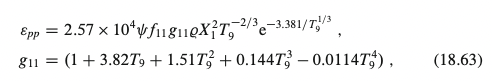

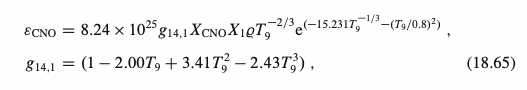

(-5.0, 5.0)

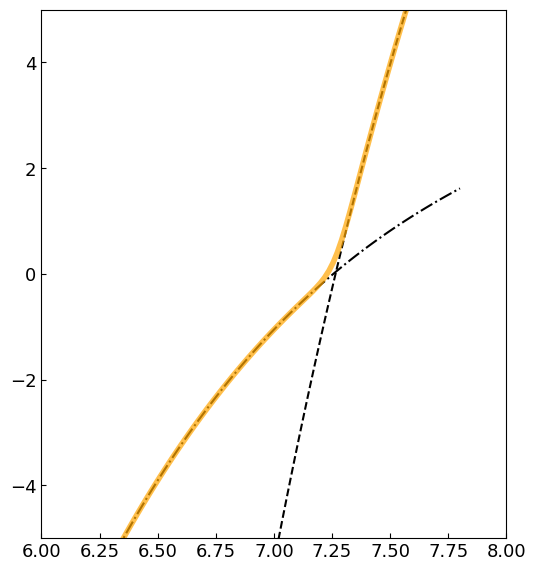

In [282]:
rho = 1
X1 = 1
T_th = 10**np.linspace(6.,7.8,100)

eps_pp = calc_eps_pp(T_th,rho,X1)
epx_CNO = calc_eps_CNO(T_th,rho,X1,XCNO=0.01)

fig,ax = plt.subplots(1,1,figsize=(6,7),dpi=100)
fig.set_facecolor('w')
ax.tick_params(direction='in',labelsize=13)
plt.plot(np.log10(T_th),np.log10(eps_pp),c='k',ls='-.')
plt.plot(np.log10(T_th),np.log10(epx_CNO),c='k',ls='--')
plt.plot(np.log10(T_th),np.log10(eps_pp+epx_CNO),c='orange',ls='-',lw=4,alpha=0.7)

plt.xlim(6,8)
plt.ylim(-5,5)

# 5

# 6. SHOOTF

In [ ]:
from scipy.optimize import minimize

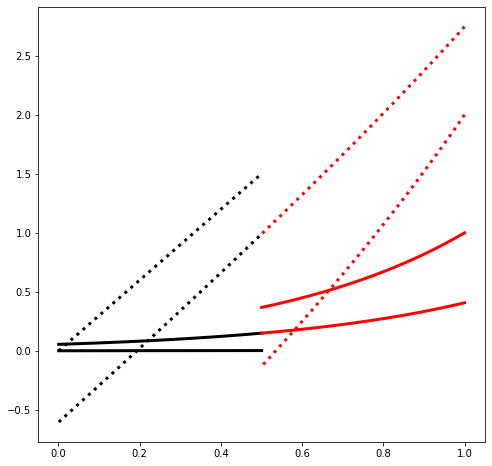

In [178]:

######
# TEST
######
x_i = 1e-3
x_f = 1

bc_i_guess = [1e-3,1e-3]
bc_f_guess = [1.0,2.0]
bc_initial_guesses = [*bc_i_guess,*bc_f_guess]
Nparams = 2

# define differential equation
def derivs(y,x):
    # y' = ay
    a = 2
    b = 3
    return [a*y[0],a*y[0]+b]


# check the best-fit values
out = shootf(f = derivs,
              x_i = x_i,
              x_f = x_f,
              bc_i_guess = bc_i_guess,
              bc_f_guess = bc_f_guess,
              return_y = True)
res, x_left, x_right, y_left,y_right = out

fig = plt.figure(figsize=(8,8))
ls = ['-',':']
for i in range(2):
    plt.plot(x_left,y_left[:,i],c='k',ls=ls[i],lw=3)
    plt.plot(x_right,y_right[:,i],c='r',ls=ls[i],lw=3)



# define a helper function that returns the value to be minimized
def minimize_helper(params):
    bc_i = params[:Nparams]
    bc_f = params[Nparams:]
    res = shootf(f = derivs,
                  x_i = x_i,
                  x_f = x_f,
                  bc_i_guess = bc_i,
                  bc_f_guess = bc_f,
                  return_y = False)
    return np.sum(np.abs(res))

# minimize
fit = minimize(minimize_helper,x0 = bc_initial_guesses)

# check the best-fit values
out = shootf(f = derivs,
              x_i = x_i,
              x_f = x_f,
              bc_i_guess = fit.x[:Nparams],
              bc_f_guess = fit.x[Nparams:],
              return_y = True)
res, x_left, x_right, y_left,y_right = out

ls = ['-',':']
for i in range(2):
    plt.plot(x_left,y_left[:,i],c='k',ls=ls[i],lw=3)
    plt.plot(x_right,y_right[:,i],c='r',ls=ls[i],lw=3)

# differential equations

In [130]:
N_A = const.N_A.cgs.value
G = const.G.cgs.value
k_B = const.k_B.cgs.value

In [180]:
from stellar_model import *

In [981]:
# define mass
M_Msol = 1.50
M = M_Msol * const.M_sun.cgs.value # stellar mass in cgs unit
M_i = M * 1e-11
M_f = M * 0.9999
M_fit = M * 0.5

# composition
X,Y,Z = 0.35,0.55,0.1#0.7,0.26,0.04
mu = 4 / (3 + 5 * X) # ~0.6

# fit parameter
n_left = int(1e5)
n_right = int(1e5)

fixed_params = [mu, X, Y, Z]

# A helper function that returns the value to be minimized
def minimize_helper(free_param_scale,free_param_initial):
    free_params = free_param_scale * free_param_initial
    if (np.array(free_params)<=0).sum()>=1:
        return 1e1000
    P_c, T_c, R, L = free_params
    bc_core = get_bc_i(free_params,M,M_i,mu,X,Z)
    bc_surf = get_bc_f(free_params,M,mu)
#     res = shootf(f = lambda y,x: derivs(y,x,fixed_params),
#                   x_i = M_i,
#                   x_f = M,
# #                   x_fit = M_i,
#                   bc_i_guess = bc_core,
#                   bc_f_guess = bc_surf,
#                   return_y = False)
    
    # integrate
    res = shoot_out(f = lambda y,x: derivs(y,x,fixed_params),
                  x_i = M_i,
                  x_f = M_f ,
                  x_fit = M_fit,
                  bc_i_guess = bc_core,
                  bc_f_guess = bc_surf,
                  return_y = False,
                  n_left = n_left,
                  n_right = n_right)
    
    bc_scales = np.max([bc_core,bc_surf],axis=0)
    chi2 = (res/bc_scales)**2
    for c2 in chi2:
        print(f'{c2:6.3e}\t',end='')
    print('')
    return np.sum(chi2)

# initial guessses for free parameters
# use constant density models and homology relations
R = const.R_sun.cgs.value * M_Msol**0.75 
L = const.L_sun.cgs.value * M_Msol**3.5 
P_c = 3 * G * M**2 / (8 * np.pi * R**4) 
T_c = G * M * mu / (2 * R * N_A * k_B) 
free_params_guess = np.array([P_c,T_c,R,L])
bounds = np.array([[0.1]*4,[10]*4]).T

# scale parameters
bc_core_i = get_bc_i(free_params_guess,M,M_i,mu,X,Z)
bc_surf_i = get_bc_f(free_params_guess,M,mu)
bc_scales = np.max([bc_core_i,bc_surf_i],axis=0)

# fit!
fit = minimize(minimize_helper,x0 = [1,1,1,1],
               args=(free_params_guess),
               bounds = bounds)

9.975e-01	1.276e-01	7.207e-02	9.987e-01	
9.975e-01	1.276e-01	7.207e-02	9.987e-01	
9.975e-01	1.276e-01	7.207e-02	9.987e-01	
9.975e-01	1.276e-01	7.207e-02	9.987e-01	
9.975e-01	1.276e-01	7.207e-02	9.987e-01	
9.999e-01	2.266e-03	1.248e-02	9.981e-01	
9.999e-01	2.266e-03	1.248e-02	9.981e-01	
9.999e-01	2.266e-03	1.248e-02	9.981e-01	
9.999e-01	2.266e-03	1.248e-02	9.981e-01	
9.999e-01	2.266e-03	1.248e-02	9.981e-01	
1.000e+00	7.128e-10	2.579e+01	9.897e-01	
1.000e+00	7.128e-10	2.579e+01	9.897e-01	
1.000e+00	7.128e-10	2.579e+01	9.897e-01	
1.000e+00	7.128e-10	2.579e+01	9.897e-01	
1.000e+00	7.128e-10	2.579e+01	9.897e-01	
1.000e+00	1.366e-04	3.740e-02	9.974e-01	
1.000e+00	1.366e-04	3.740e-02	9.974e-01	
1.000e+00	1.366e-04	3.740e-02	9.974e-01	
1.000e+00	1.366e-04	3.740e-02	9.974e-01	
1.000e+00	1.366e-04	3.740e-02	9.974e-01	
9.999e-01	8.113e-04	4.143e-04	9.978e-01	
9.999e-01	8.113e-04	4.143e-04	9.978e-01	
9.999e-01	8.113e-04	4.143e-04	9.978e-01	
9.999e-01	8.113e-04	4.143e-04	9.978e-01	
9.999e-01	8.113e

In [982]:
fit

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.9508852435563395
        x: [ 1.000e+01  1.709e-01  6.174e+00  1.000e+01]
      nit: 59
      jac: [-1.096e-02  1.468e-03  4.481e-05 -1.350e-04]
     nfev: 455
     njev: 91
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

# check

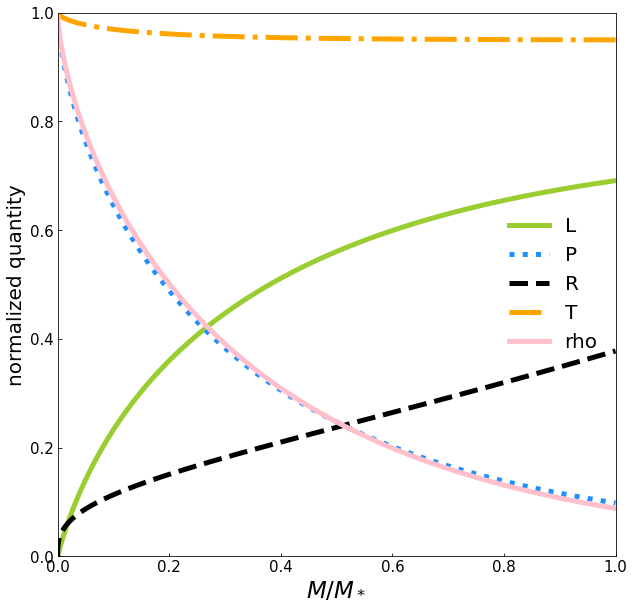

In [998]:
# define mass
M_Msol = 3.0
M = M_Msol * const.M_sun.cgs.value # stellar mass in cgs unit
M_i = M * 1e-26
M_f = M * 0.99999
M_fit = M * 0.5#999

# composition
X,Y,Z = 0.35,0.55,0.1#0.7,0.26,0.04
mu = 4 / (3 + 5 * X) # ~0.6

# fit parameter
n_left = int(2e6)
n_right = int(1e5)
grid_log_scale = int(1e12)

# set free parameters - P_c, T_c, R, L
# R = const.R_sun.cgs.value * M_Msol**0.75 
# L = const.L_sun.cgs.value * M_Msol**3.5 
# P_c = 3 * G * M**2 / (8 * np.pi * R**4) 
# T_c = G * M * mu / (2 * R * N_A * k_B) 
# bestfit_params = np.array([P_c,T_c,R,L])
# bestfit_params = free_params_guess
# bestfit_params = [1e+17,2.7e7,1.5e11,2.4e36]
bestfit_params = [2.48e+16,2.1e7,2.2e11,4.6e35]
bc_core = get_bc_i(bestfit_params,M,M_i,mu,X,Z)
bc_surf = get_bc_f(bestfit_params,M,mu)

# integrate
out = shoot_out(f = lambda y,x: derivs(y,x,fixed_params),
              x_i = M_i,
              x_f = M_f ,
              x_fit = M_fit,
              bc_i_guess = bc_core,
              bc_f_guess = bc_surf,
              return_y = True,
              n_left = n_left,
              n_right = n_right,
              grid_log_scale = grid_log_scale)

# parse outputs
res, x_sol, y_sol = out
l,p,r,t = y_sol
rho = calc_density(p,t,mu)

#  plot
vals = [l,p,r,t,rho]
colors = ['yellowgreen','dodgerblue','k','orange','pink']
lss = ['-',':','--','-.','-']
labels = ['L','P','R','T','rho']
ymax = [*np.nanmax([bc_core,bc_surf],axis=0),rho.max()]

fig,ax = plt.subplots(1,1,figsize=(10,10))
fig.set_facecolor('w')
for y,_ymax, c,ls,label in zip(vals,ymax,colors,lss,labels):
    xval = x_sol/M
    ax.plot(xval[::10], (y/_ymax)[::10],
                 c=c, ls=ls, lw=5, label=label)
ax.tick_params(direction='in',labelsize=15)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend(frameon=False,fontsize=20)
ax.set_xlabel(r'$M/M_*$',fontsize=23)
ax.set_ylabel(r'normalized quantity',fontsize=20)
plt.show()

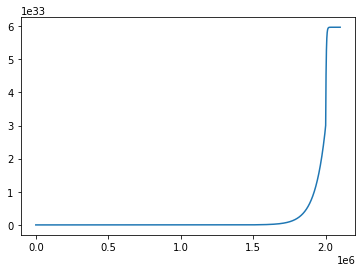

In [999]:
plt.plot(x_sol)

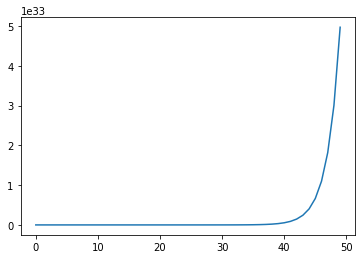

In [873]:
plt.plot(np.geomspace(M_i,M_fit))

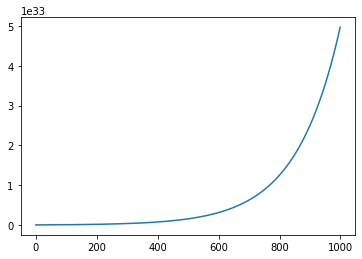

In [892]:
def gen_logspaced_grid(start_val,final_val,n_x,log_scale=1000):
    scale = (final_val - start_val)
    spacing = (np.geomspace(1,log_scale,n_x)-1) / log_scale * scale
    gridpoints = start_val + spacing
    return gridpoints
grid = gen_logspaced_grid(M_i,M_fit,1000)
plt.plot(grid)

In [837]:
y_sol = np.concatenate([y_left,np.flip(y_right)]).T

np.append(y_sol,)

NameError: name 'y_sol' is not defined

array([9.94204935e+22, 9.84273723e+28, 1.96854645e+29, ...,
       9.94105318e+33, 9.94105416e+33, 9.94105515e+33])

In [836]:
np.concatenate([y_left,np.flip(y_right)])

(200000,)

In [ ]:
np.reverse(x)

/Users/sterling/Dropbox/courses/Stellar/stellar_model.py:117: RuntimeWarning: overflow encountered in power
  P_gas = np.asarray(P - P_rad)
/Users/sterling/Dropbox/courses/Stellar/stellar_model.py:125: RuntimeWarning: divide by zero encountered in true_divide
  # Radiation pressure
/Users/sterling/Dropbox/courses/Stellar/stellar_model.py:125: RuntimeWarning: overflow encountered in true_divide
  # Radiation pressure
/Users/sterling/Dropbox/courses/Stellar/stellar_model.py:125: RuntimeWarning: invalid value encountered in true_divide
  # Radiation pressure


(0.0, 1e+32)

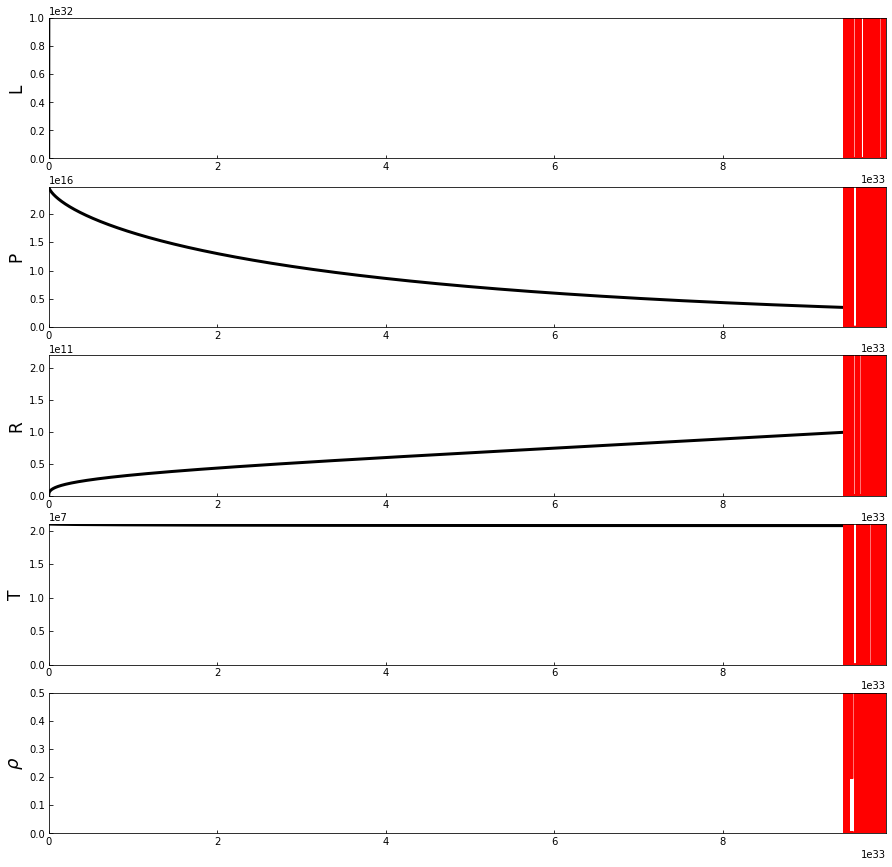

In [812]:
M_Msol = 5.0
M = M_Msol * const.M_sun.cgs.value # stellar mass in cgs unit
M_i = M/1e11#1e5 # grams!
Nparams = 4
X,Y,Z = 0.35,0.55,0.1#0.7,0.26,0.04
mu = 4 / (3 + 5 * X) # ~0.6

# check the best-fit values
bestfit_params = fit.x
# P_c, T_c, R, L
# bestfit_params = [1e+17,2.7e7,1.5e11,2.4e36]#free_params_guess

bestfit_params = [2.48e+16,2.1e7,2.2e11,1.9e36]#free_params_guess

out = shootf(f = lambda y,x: derivs(y,x,fixed_params),
              x_i = M_i,
              x_f = M*0.999,
              bc_i_guess = get_bc_i(bestfit_params,M,M_i,mu),
              bc_f_guess = get_bc_f(bestfit_params,M,mu),
              x_fit = 0.95*M,
              return_y = True,
              n_x = 10000)
res, x_left, x_right, y_left,y_right = out

ls = ['-',':','--','-.']
labels = ['L','P','R','T']
ymax = np.maximum(get_bc_i(bestfit_params,M,M_i,mu),
                  get_bc_f(bestfit_params,M,mu))

fig,axes = plt.subplots(5,1,figsize=(15,15))
fig.set_facecolor('w')
for i in range(4):
    
    axes[i].plot(x_left,y_left[:,i],c='k',lw=3)
    axes[i].plot(x_right,y_right[:,i],c='r',lw=3)
    axes[i].set_ylabel(labels[i],fontsize=17)
    axes[i].set_ylim(0,ymax[i])
    
T = y_right[:,-1]
P = y_right[:,1]
rho_right = calc_density(y_right[:,1],y_right[:,-1],mu)
rho_left = calc_density(y_left[:,1],y_left[:,-1],mu)
axes[-1].plot(x_right,rho_right,c='red',lw=3)
axes[-1].plot(x_left,rho_left,c='k',lw=3)
axes[-1].set_ylabel(r'$\rho$',fontsize=18)
axes[-1].set_ylim(0,0.5)
for ax in axes:
    ax.set_xlim(0,x_right.max())
    ax.tick_params(direction='in')
axes[0].set_ylim(0,1e32)
#     ax.set_xlim(0.999998*x_right.max(),x_right.max())a

In [ ]:
[[1,1]]
[1,1]

In [769]:
y_right[:,0]

array([1.06995853e+36, 1.06995853e+36, 1.06995853e+36, ...,
       1.06995852e+36, 1.06995852e+36, 1.06995852e+36])

In [751]:
rho_right

array([5.73057014e-10, 8.90892569e-07, 1.67804953e-01, ...,
       8.77487394e-02, 8.77486991e-02, 8.77486589e-02])

In [810]:
1/const.N_A.cgs, const.m_p.cgs

(<Quantity 1.66053907e-24 mol>, <Quantity 1.67262192e-24 g>)

# diagnostics

Text(1.3, 0.5, 'log opacity')

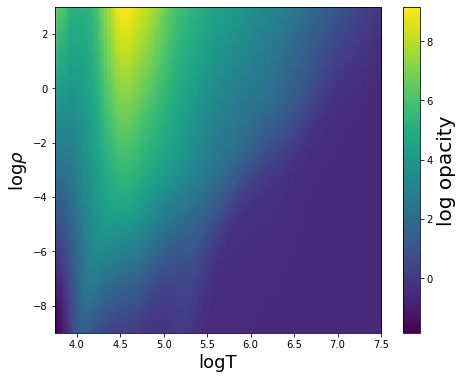

In [479]:
logrho_th = np.linspace(-9,3,100)
logT_th = np.linspace(3.75,7.5,100)
xx,yy = np.meshgrid(logT_th,logrho_th)

log_opacity = np.log10(calc_opacity(xx,10**yy))

fig,ax = plt.subplots(1,1,figsize=(8,6))
fig.set_facecolor('w')
im = plt.imshow(log_opacity.T,origin='lower',
           extent=([3.75,7.5,-9,3]),
           aspect=(7.5-3.75)/(9+3))
ax.set_xlabel('logT',fontsize=18)
ax.set_ylabel(r'log$\rho$',fontsize=18)
cb = fig.colorbar(im)
cb.ax.set_ylabel('log opacity',x=1.3,fontsize=20)

<ipython-input-668-39f39bb5769a>:3: RuntimeWarning: invalid value encountered in double_scalars
  T = (3/4 * L / (4*np.pi*sigma_sb*R**2) * (tau + 2/3))**(1/4)


1062.0639667491869